In [1]:

#%%
import pandas as pd
import numpy as np
import os
import datetime
import re
os.chdir(re.split('transport_data_system', os.getcwd())[0]+'/transport_data_system')
import sys
folder_path = './aggregation_code'  # Replace with the actual path of the folder you want to add
sys.path.append(folder_path)
import utility_functions 
#%%
#TAKE IN ROAD DATA
wb = pd.ExcelFile('./input_data/Manually_inputted_data_road.xlsx')
concat_df_road = pd.DataFrame()
for sheet in wb.sheet_names:
    df = pd.read_excel(wb,sheet)
    if sheet != 'concordance':
        concat_df_road = pd.concat([concat_df_road,df],ignore_index=True)

    else:
        concordance_road = df.copy()
#TAKE IN NON ROAD DATA
wb = pd.ExcelFile('./input_data/Manually_inputted_data_other.xlsx')
concat_df_other = pd.DataFrame()
for sheet in wb.sheet_names:
    df = pd.read_excel(wb,sheet)
    if sheet != 'concordance':
        concat_df_other = pd.concat([concat_df_other,df],ignore_index=True)

    else:
        concordance_other = df.copy()


def extend_df_for_missing_dates(df,concordance_df):
    #now we want to fill in with as many dates as we need. For now we will assume that is between 2010 and the current year
    current_year = datetime.datetime.now().year
    years = np.arange(2010,current_year+1)
    #convert years to yyyy-mm-dd by adding 12-31 to end
    years = [str(year)+'-12-31' for year in years]
    #make sure date in concat_df_road is a str
    df['Date'] = df['Date'].astype(str)

    #now for every row in concat_df_road we want to add a row for each date in years. We'll use pd.repeat to do this.
    #first create version of df withno values col
    df_no_values = df.drop('Value',axis=1)
    df_no_values = df_no_values.reindex(df_no_values.index.repeat(len(years)))
    df_no_values['Date'] = years * len(df)
    df_no_values.reset_index(drop=True, inplace=True)
    #add the values column back in using merge
    df = df_no_values.merge(df,how='left',on=df_no_values.columns.tolist())

    #fill missing values with the value from the closest date
    df['Value'] = df.groupby(concordance_df.columns.tolist())['Value'].apply(lambda x: x.ffill().bfill())

    return df

concat_df_road = extend_df_for_missing_dates(concat_df_road,concordance_road)
concat_df_other = extend_df_for_missing_dates(concat_df_other,concordance_other)

def convert_occupancy_and_load_to_occupancy_or_load(df):
    #take in the data for occupan and laod and combine them into one measure
    #note that this is likely to be use for some time.
    occ_load = df[df['Measure'].isin(['Occupancy', 'Load'])]
    occ_load['Measure'] = 'Occupancy_or_load'
    #repalce unit with passengers_or_tonnes
    occ_load['Unit'] = 'Passengers_or_tonnes'
    #drop these rows from the original df
    df = df[~df['Measure'].isin(['Occupancy', 'Load'])]
    #concat the two dfs
    df = pd.concat([df, occ_load], ignore_index=True)
    return df

concat_df_road = convert_occupancy_and_load_to_occupancy_or_load(concat_df_road)
#%%
def create_phev_and_ice_versions_of_values(df):
    #because we are not sure if we will introduice these aggregations for good we will itnroduce these using code. Just extract the values for phevg/phevd and g/d drive types and set their drive to phev and ice respectively, then group by all cols except value and average. then add them back into the df
    phev = df[df['Drive'].isin(['phevg','phevd'])]
    phev['Drive'] = 'phev'
    cols = phev.columns.tolist()
    cols.remove('Value')
    phev = phev.groupby(cols).mean().reset_index()

    ice = df[df['Drive'].isin(['g','d'])]
    ice['Drive'] = 'ice'
    cols = ice.columns.tolist()
    cols.remove('Value')
    ice = ice.groupby(cols).mean().reset_index()

    df = pd.concat([df, phev, ice], ignore_index=True)

    return df

concat_df_road = create_phev_and_ice_versions_of_values(concat_df_road)  
#%%
def save_df_to_csv(df,save_path, file_name_start):
    #now we want to save the data to csv. but make sure this data si different from the previous version of the data
    #get the date of the previous version of the data
    prev_file_date = utility_functions.get_latest_date_for_data_file(save_path, file_name_start)
        
    if prev_file_date == None:
        #save the data
        FILE_DATE_ID = 'DATE{}'.format(datetime.datetime.now().strftime('%Y%m%d'))
        df.to_csv(f'./intermediate_data/{file_name_start}{FILE_DATE_ID}.csv',index=False)
    else:
        FILE_DATE_ID_prev = 'DATE{}'.format(prev_file_date)
        prev_file_path = f'./intermediate_data/{file_name_start}{FILE_DATE_ID_prev}.csv'

        if utility_functions.compare_data_to_previous_version_of_data_in_csv(df,prev_file_path):
            #save the data
            FILE_DATE_ID = 'DATE{}'.format(datetime.datetime.now().strftime('%Y%m%d'))
            df.to_csv(f'./intermediate_data/{file_name_start}{FILE_DATE_ID}.csv',index=False)

# #%%
# save_df_to_csv(concat_df_road,'./intermediate_data/estimated','manually_inputted_data_cleaned_road')
# save_df_to_csv(concat_df_other,'./intermediate_data/estimated','manually_inputted_data_cleaned_other')



# print('Done')
# #%%

/tmp/ipykernel_1316/1349614456.py:54: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['Value'] = df.groupby(concordance_df.columns.tolist())['Value'].apply(lambda x: x.ffill().bfill())
/tmp/ipykernel_1316/1349614456.py:54: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['Value'] = df.groupby(c

/tmp/ipykernel_1316/2620626542.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  concat_df_road[concat_df_road.Measure=='Mileage'].groupby('Date').mean().reset_index().plot(x='Date',y='Value',kind='scatter')


<Axes: xlabel='Date', ylabel='Value'>

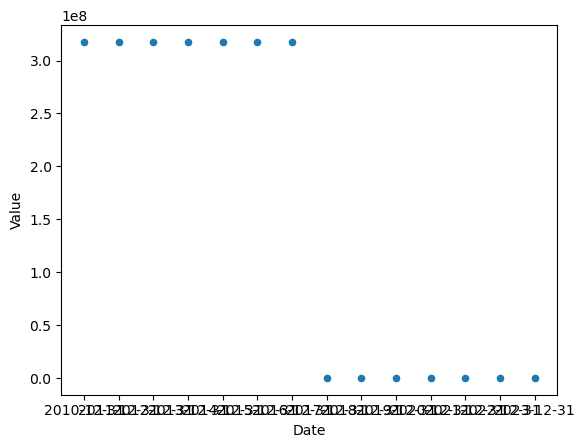

In [6]:
#calc mean by year
concat_df_road[concat_df_road.Measure=='Mileage'].groupby('Date').mean().reset_index().plot(x='Date',y='Value',kind='scatter')



In [7]:
concat_df_road[concat_df_road.Measure=='Mileage'].groupby('Date').mean()

/tmp/ipykernel_1316/1352917296.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  concat_df_road[concat_df_road.Measure=='Mileage'].groupby('Date').mean()


,Value
Date,
2010-12-31,3.175998e+08
2011-12-31,3.175998e+08
2012-12-31,3.175998e+08
2013-12-31,3.175998e+08
2014-12-31,3.175998e+08
2015-12-31,3.175998e+08
2016-12-31,3.175998e+08
2017-12-31,5.365385e+04
2018-12-31,5.365385e+04


In [12]:
#for some reasdon the mean of values halfs from 2017 onwards. We should see what the count of row combinations is for each year for certain cols.
x = concat_df_road[concat_df_orad.Measure=='Mileage']
x = x.groupby(['Date','Drive','Vehicle Type']).count().reset_index()

In [15]:
concat_df_road[concat_df_road.duplicated()]


,Medium,Transport Type,Vehicle Type,Drive,Date,Economy,Frequency,Measure,Unit,Dataset,Scope,Comments,Fuel,Source,Value


In [16]:

#%%
import pandas as pd
import numpy as np
import os
import datetime
import re
os.chdir(re.split('transport_data_system', os.getcwd())[0]+'/transport_data_system')
import sys
folder_path = './aggregation_code'  # Replace with the actual path of the folder you want to add
sys.path.append(folder_path)
import utility_functions 
#%%
#TAKE IN ROAD DATA
wb = pd.ExcelFile('./input_data/Manually_inputted_data_road.xlsx')
concat_df_road = pd.DataFrame()
for sheet in wb.sheet_names:
    df = pd.read_excel(wb,sheet)
    if sheet != 'concordance':
        concat_df_road = pd.concat([concat_df_road,df],ignore_index=True)

    else:
        concordance_road = df.copy()
#TAKE IN NON ROAD DATA
wb = pd.ExcelFile('./input_data/Manually_inputted_data_other.xlsx')
concat_df_other = pd.DataFrame()
for sheet in wb.sheet_names:
    df = pd.read_excel(wb,sheet)
    if sheet != 'concordance':
        concat_df_other = pd.concat([concat_df_other,df],ignore_index=True)

    else:
        concordance_other = df.copy()



In [17]:
concat_df_road

,Medium,Transport Type,Vehicle Type,Drive,Date,Economy,Frequency,Measure,Unit,Value,Dataset,Scope,Comments,Fuel,Source
0,road,passenger,2w,bev,2017-12-31,01_AUS,Yearly,Occupancy,Passengers,1.1,Manually_inputted_data,National,no_comment,All,guess
1,road,passenger,2w,g,2017-12-31,01_AUS,Yearly,Occupancy,Passengers,1.1,Manually_inputted_data,National,no_comment,All,guess
2,road,passenger,bus,cng,2017-12-31,01_AUS,Yearly,Occupancy,Passengers,15.0,Manually_inputted_data,National,no_comment,All,guess
3,road,passenger,bus,d,2017-12-31,01_AUS,Yearly,Occupancy,Passengers,15.0,Manually_inputted_data,National,no_comment,All,guess
4,road,passenger,bus,g,2017-12-31,01_AUS,Yearly,Occupancy,Passengers,15.0,Manually_inputted_data,National,no_comment,All,guess
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,road,passenger,ldv,d,2017-12-31,21_VN,Yearly,Mileage,km_per_stock,15000.0,Manually_inputted_data,National,no_comment,All,guess
2936,road,passenger,ldv,fcev,2017-12-31,21_VN,Yearly,Mileage,km_per_stock,15000.0,Manually_inputted_data,National,no_comment,All,guess
2937,road,passenger,ldv,g,2017-12-31,21_VN,Yearly,Mileage,km_per_stock,15000.0,Manually_inputted_data,National,no_comment,All,guess
2938,road,passenger,ldv,lpg,2017-12-31,21_VN,Yearly,Mileage,km_per_stock,15000.0,Manually_inputted_data,National,no_comment,All,guess


In [ ]:

# def extend_df_for_missing_dates(df,concordance_df):
#     #now we want to fill in with as many dates as we need. For now we will assume that is between 2010 and the current year
#     current_year = datetime.datetime.now().year
#     years = np.arange(2010,current_year+1)
#     #convert years to yyyy-mm-dd by adding 12-31 to end
#     years = [str(year)+'-12-31' for year in years]
#     #make sure date in concat_df_road is a str
#     df['Date'] = df['Date'].astype(str)

#     #now for every row in concat_df_road we want to add a row for each date in years. We'll use pd.repeat to do this.
#     #first create version of df withno values col
#     df_no_values = df.drop('Value',axis=1)
#     df_no_values = df_no_values.reindex(df_no_values.index.repeat(len(years)))
#     df_no_values['Date'] = years * len(df)
#     df_no_values.reset_index(drop=True, inplace=True)
#     #add the values column back in using merge
#     df = df_no_values.merge(df,how='left',on=df_no_values.columns.tolist())

#     #fill missing values with the value from the closest date
#     df['Value'] = df.groupby(concordance_df.columns.tolist())['Value'].apply(lambda x: x.ffill().bfill())

#     return df

# concat_df_road = extend_df_for_missing_dates(concat_df_road,concordance_road)
# concat_df_other = extend_df_for_missing_dates(concat_df_other,concordance_other)

In [19]:
concat_df_road

,Medium,Transport Type,Vehicle Type,Drive,Date,Economy,Frequency,Measure,Unit,Value,Dataset,Scope,Comments,Fuel,Source
0,road,passenger,2w,bev,2017-12-31,01_AUS,Yearly,Occupancy,Passengers,1.1,Manually_inputted_data,National,no_comment,All,guess
1,road,passenger,2w,g,2017-12-31,01_AUS,Yearly,Occupancy,Passengers,1.1,Manually_inputted_data,National,no_comment,All,guess
2,road,passenger,bus,cng,2017-12-31,01_AUS,Yearly,Occupancy,Passengers,15.0,Manually_inputted_data,National,no_comment,All,guess
3,road,passenger,bus,d,2017-12-31,01_AUS,Yearly,Occupancy,Passengers,15.0,Manually_inputted_data,National,no_comment,All,guess
4,road,passenger,bus,g,2017-12-31,01_AUS,Yearly,Occupancy,Passengers,15.0,Manually_inputted_data,National,no_comment,All,guess
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,road,passenger,ldv,d,2017-12-31,21_VN,Yearly,Mileage,km_per_stock,15000.0,Manually_inputted_data,National,no_comment,All,guess
2936,road,passenger,ldv,fcev,2017-12-31,21_VN,Yearly,Mileage,km_per_stock,15000.0,Manually_inputted_data,National,no_comment,All,guess
2937,road,passenger,ldv,g,2017-12-31,21_VN,Yearly,Mileage,km_per_stock,15000.0,Manually_inputted_data,National,no_comment,All,guess
2938,road,passenger,ldv,lpg,2017-12-31,21_VN,Yearly,Mileage,km_per_stock,15000.0,Manually_inputted_data,National,no_comment,All,guess


In [20]:

# def extend_df_for_missing_dates(df,concordance_df):
#now we want to fill in with as many dates as we need. For now we will assume that is between 2010 and the current year
df = concat_df_road
concordance_df = concordance_road

current_year = datetime.datetime.now().year
years = np.arange(2010,current_year+1)
#convert years to yyyy-mm-dd by adding 12-31 to end
years = [str(year)+'-12-31' for year in years]
#make sure date in concat_df_road is a str
df['Date'] = df['Date'].astype(str)

#now for every row in concat_df_road we want to add a row for each date in years. We'll use pd.repeat to do this.
#first create version of df withno values col
df_no_values = df.drop('Value',axis=1)
df_no_values = df_no_values.reindex(df_no_values.index.repeat(len(years)))
df_no_values['Date'] = years * len(df)
df_no_values.reset_index(drop=True, inplace=True)
#add the values column back in using merge
df = df_no_values.merge(df,how='left',on=df_no_values.columns.tolist())

cols=df.columns.tolist() 
#drop ['Source', 'Comments', 'Value', 'Dataset', 'Date'] from cols
cols = [col for col in cols if col not in ['Source', 'Comments', 'Value', 'Dataset', 'Date']]
df['Value'] = df.groupby(cols)['Value'].apply(lambda x: x.ffill().bfill())
# return df

# concat_df_road = extend_df_for_missing_dates(concat_df_road,concordance_road)
# concat_df_other = extend_df_for_missing_dates(concat_df_other,concordance_other)

In [22]:

#fill missing values with the value from the closest date
# df['Value'] = df.groupby(concordance_df.columns.tolist())['Value'].apply(lambda x: x.ffill().bfill())
concordance_df.columns.tolist()

['Vehicle Type', 'Transport Type', 'Drive', 'Medium', 'Economy']

In [23]:
df.groupby(concordance_df.columns.tolist())['Value'].apply(lambda x: x.ffill().bfill())

/tmp/ipykernel_1316/1827209184.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df.groupby(concordance_df.columns.tolist())['Value'].apply(lambda x: x.ffill().bfill())


0            1.1
1            1.1
2            1.1
3            1.1
4            1.1
          ...   
41155    15000.0
41156    15000.0
41157    15000.0
41158    15000.0
41159    15000.0
Name: Value, Length: 41160, dtype: float64

In [29]:
#df.columns.tolist()
# compare diff in cols between 
# cols=['Medium',
#  'Transport Type',
#  'Vehicle Type',
#  'Drive',
#  'Economy',
#  'Frequency',
#  'Measure',
#  'Unit',
#  'Scope',
#  'Fuel'] and df.columns.tolist()

cols=['Medium',
 'Transport Type',
 'Vehicle Type',
 'Drive',
 'Economy',
 'Frequency',
 'Measure',
 'Unit',
 'Scope',
 'Fuel']
diff = list(set(df.columns.tolist()) - set(cols))

In [30]:
diff

['Source', 'Comments', 'Value', 'Dataset', 'Date']